## week12: Convolutional neural networks

Inspiration for this notebook is taken from YSDA materials

__Colab is highly recommended to work with this notebook__

# Task: Cats vs. Dogs Classification

<img src="img/cat_dog_sota.jpg" width="600">




Let's try to build a small convolutional neural network capable of separating cat images from dog images.

## Datasets in pyTorch

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as *Pillow*, *OpenCV* are useful
- For audio, packages such as *scipy* and *librosa*
- For text, either raw *Python* or *Cython* based loading, or *NLTK* and *SpaCy* are useful

We are dealing with images, so let's have a look at image data loading in pyTorch for [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) classification competition.

The link for data downloading is in the cell below.

Training set size is reduced for performace. If you have enough computational resources, use [this link](https://www.dropbox.com/s/h2vhfxb0j3eazu1/train.zip) for downloading instead of the latter one.

In [ ]:
# Training set with 11K images
! wget https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
! unzip -qq data.zip -d data

Now let's look at the way datasets are processed in PyTorch.

In [ ]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Images should be stored class-wise in PC memory: each image class have to be represented as a subfolder with the corresponding image data. `ImageFolder` takes the path to 'root' directory of such structure, e.g. DATA_PATH:

- DATA_PATH/dog/xxx.png
- DATA_PATH/dog/xxy.png
- DATA_PATH/dog/xxz.png
- DATA_PATH/cat/123.png
- DATA_PATH/cat/nsdf3.png
- DATA_PATH/cat/asd932_.png

Dataset images are of different size.

Batch generator expects a batch of tensors of the same dimensions, thus we need to rescale images in the dataset during data loading.

Let's see at the image size distributions.

In [ ]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = r"kaggle/input/dog-and-cat-classification-dataset/PetImages" # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 64, we use this to speed up training
SIZE_H = SIZE_W = 96

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 128

Let's define a transformer to be used as image preprocessing step prior to creating pyTorch image dataset

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Create an ImageFolder instance to be used during training, validation and testing phases.

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
# print(path)

# load dataset using torchvision.datasets.ImageFolder
train_dataset = torchvision.datasets.ImageFolder(DATA_PATH, transform=transformer)
class_names = train_dataset.classes

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))  # 80% для обучения
test_size = len(train_dataset) - train_size  # 20% для теста

# Разделяем случайным образом
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))  # 80% для обучения
val_size = len(train_dataset) - train_size  # 20% для теста

# Разделяем случайным образом
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

Save sample num for further use

In [ ]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)
print(n_train, n_val)

15998 4000


Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [ ]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

In [ ]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             num_workers=NUM_WORKERS)

Let's create a helper function to vizualize images from our data loaders (and also make sure data was properly loaded).

In [ ]:
def plot_from_batch_generator(batch_gen, class_names):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):

        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

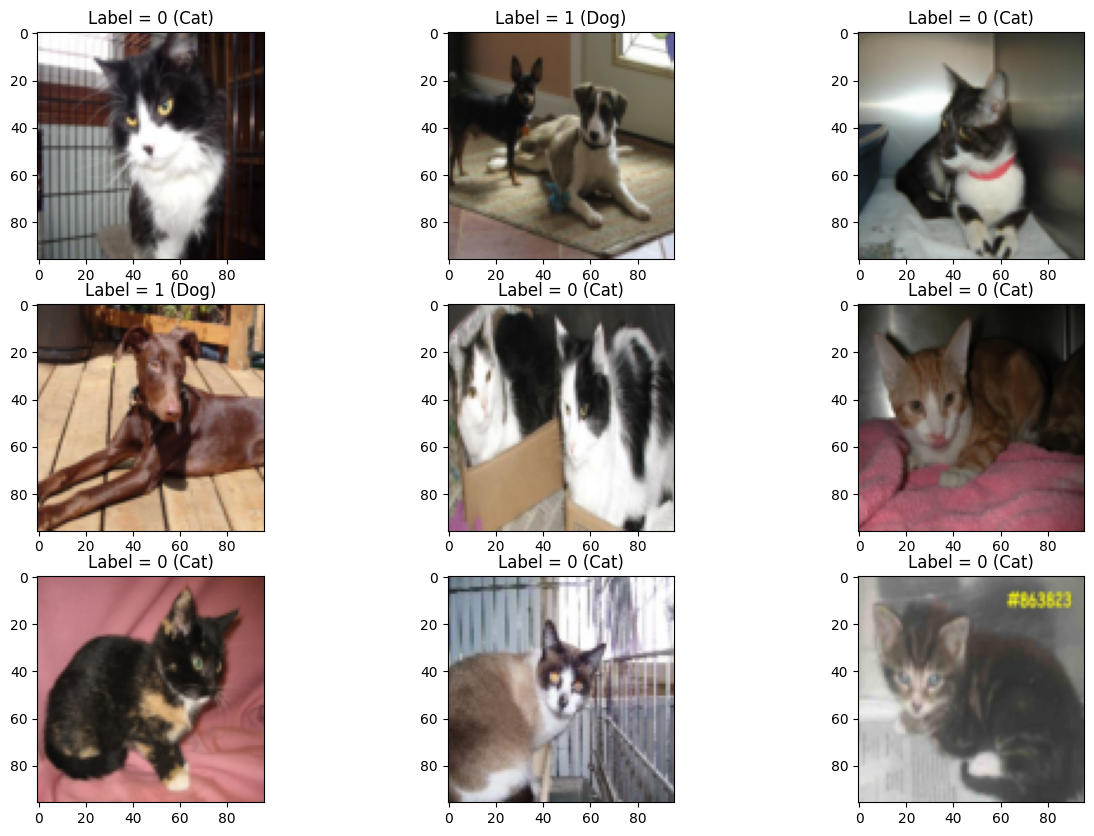

In [ ]:
plot_from_batch_generator(train_batch_gen, class_names)


# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

Let's use them to create a baseline for our models.

The following cell implements helper CNN layer.

In [ ]:
# a special module that converts [batch, channel, w, h] to [batch, units]: tf/keras style
class Flatten(nn.Module):
    def forward(self, x):
        # finally we have it in pytorch
        return torch.flatten(x, start_dim=1)

## Task 0: Multi-layer fully-connected network

Look at the NN structure proposed below.

We will use this model as a baseline for classification task.

As you already know, fully-connetcted networks are not translation invariant and perform worse on image data, so resulting accuracy will be lower than for convolutional neural networks.

In [ ]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * SIZE_H * SIZE_W, 256))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(0.1))
model.add_module('dense3', nn.Linear(256, EMBEDDING_SIZE))
model.add_module('dense3_relu', nn.ReLU())
model.add_module('dropout3', nn.Dropout(0.1))
# logits for NUM_CLASSES=2: cats and dogs
model.add_module('dense4_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))

Print model summary for sanity check:

In [ ]:
summary(model, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                  [-1, 256]       7,078,144
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.22
Params size (MB): 27.13
Estimated Total Size (MB): 27.45
----------------------------------------------------------------


## Construct training pipeline

Now that we can properly load the data and define the NN model structure in terms of input/output, we need to build functions, that will perform forward and backward passes for the model so the backpropagation will optimize the NN weights in accordance with used loss function.

**Question**: What loss funtion do we need to use for the classification task?

In [ ]:
loss_function = nn.CrossEntropyLoss()

def compute_loss(model, data_batch):
    """ Compute the loss using loss_function for the batch of data and return mean loss value for this batch."""
    # load the data
    img_batch = data_batch['img']
    label_batch = data_batch['label']

    # forward pass
    logits = model(img_batch)

    # loss computation
    loss = loss_function(logits, label_batch)

    return loss, model

In [ ]:
# test your loss function calculation
batch_size_test = 8
img = np.random.randint(0, 255, size=(batch_size_test,3, SIZE_H, SIZE_W)).astype(np.float32) / 255
img = (img - np.array(image_mean).reshape(1, 3, 1, 1)) / np.array(image_std).reshape(1,3,1,1)
img_tensor = torch.Tensor(img)
label = torch.Tensor(np.random.randint(0,2, size=batch_size_test)).type(torch.long)
data_batch = {'img': img_tensor, 'label': label}
loss, model = compute_loss(model, data_batch)
loss_np = loss.detach().cpu().numpy()

assert loss_np.size == 1, 'compute_loss() shall return a single value of a loss averaged over a batch of samples'

print('Loss value: {}'.format(loss.detach().cpu().numpy()))

Loss value: 0.6724822521209717


We will also need some training progress monitoring. We would like to calculate classification metrics on the validation set each epoch and plot score distributions for the two classes we have.

All the necessary stuff is implemented in the following cell. If you wish to add more binary classification metrics, feel free to do it.

In [ ]:
from sklearn.metrics import f1_score

def accuracy(scores, labels, threshold=0.5):
    assert type(scores) is np.ndarray and type(labels) is np.ndarray
    predicted = np.array(scores > threshold).astype(np.int32)
    return np.mean(predicted == labels)

def f1(scores, labels, threshold=0.5):
    assert type(scores) is np.ndarray and type(labels) is np.ndarray
    predicted = np.array(scores > threshold).astype(np.int32)
    return f1_score(labels, predicted)

# you may add other metrics if you wish
tracked_metrics = {
    'accuracy': accuracy,
    'f1-score': f1
}

def calculate_metrics(scores, labels, print_log=False):
    """ Compute all the metrics from tracked_metrics dict using scores and labels."""

    assert len(labels) == len(scores), print('Label and score lists are of different size')

    scores_array = np.array(scores).astype(np.float32)
    labels_array = np.array(labels)

    metric_results = {}
    for k,v in tracked_metrics.items():
        metric_value = v(scores_array, labels_array)
        metric_results[k] = metric_value

    if print_log:
        print(' | '.join(['{}: {:.4f}'.format(k,v) for k, v in metric_results.items()]))

    return metric_results


def get_score_distributions(epoch_result_dict):
    """ Return per-class score arrays."""
    scores = epoch_result_dict['scores']
    labels = epoch_result_dict['labels']

    # save per-class scores
    for class_id in [0, 1]:
        epoch_result_dict['scores_' + str(class_id)] = np.array(scores)[np.array(labels) == class_id]

    return epoch_result_dict

The next cell implements the model evaluation part, which only calculates the scores in the forward pass given the batch generator. Optionally, it also computes the classification metrics and logs them.

**Warning:** Please note, that we will use 'dog class probability' as the CNN score to be used for score distribution plots and classification metrics, as the label of 'dog class' is '1'. In other words, here we will use output neuron 1 and not use output neuron 0.

In [ ]:
@torch.no_grad() # we do not need to save gradients on evaluation
def test_model(model, batch_generator, subset_name='test', print_log=True, plot_scores=False):
    """ Evaluate the model using data from batch_generator and metrics defined above."""

    # disable dropout / use averages for batch_norm
    model.train(False)

    # save scores, labels and loss values for performance logging
    score_list = []
    label_list = []
    loss_list = []

    for X_batch, y_batch in batch_generator:

        # do the forward pass
        logits = model(X_batch.to(device))
        scores = F.softmax(logits, 1).detach().cpu().numpy()[:, 1].tolist()
        labels = y_batch.numpy().tolist()

        # compute loss value
        loss = loss_function(logits, y_batch.to(device))

        # save the necessary data
        loss_list.append(loss.detach().cpu().numpy().tolist())
        score_list.extend(scores)
        label_list.extend(labels)

    if print_log:
        print("Results on {} set | ".format(subset_name), end='')

    metric_results = calculate_metrics(score_list, label_list, print_log)
    metric_results['scores'] = score_list
    metric_results['labels'] = label_list
    metric_results['loss'] = loss_list

    return metric_results

This cell implements the model training part

In [ ]:
from IPython.display import clear_output

def train_model(model, train_batch_generator, val_batch_generator, opt, ckpt_name=None, n_epochs=EPOCH_NUM, visualize=True):
    """
    Run training: forward/backward pass using train_batch_generator and evaluation using val_batch_generator.
    Log performance using loss monitoring and score distribution plots for validation set.
    """

    train_loss, val_loss = [], [1]
    val_loss_idx = [0]
    best_model = None
    top_val_accuracy = 0

    for epoch in range(n_epochs):
        start_time = time.time()

        # Train phase
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training', leave=False):

            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            data_batch = {'img': X_batch, 'label': y_batch}

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            loss, model = compute_loss(model, data_batch)

            # compute backward pass
            loss.backward()
            opt.step()
            opt.zero_grad()

            # log train loss
            train_loss.append(loss.detach().cpu().numpy())

        # Evaluation phase
        metric_results = test_model(model, val_batch_generator, subset_name='val')
        metric_results = get_score_distributions(metric_results)

        if visualize:
            clear_output()

        # Logging
        val_loss_value = np.mean(metric_results['loss'])
        val_loss_idx.append(len(train_loss))
        val_loss.append(val_loss_value)


        if visualize:
            # tensorboard for the poor
            fig = plt.figure(figsize=(15,5))
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122)

            ax1.plot(train_loss, color='b', label='train')
            ax1.plot(val_loss_idx, val_loss, color='c', label='val')
            ax1.legend()
            ax1.set_title('Train/val loss.')

            ax2.hist(metric_results['scores_0'], bins=50, range=[0,1.01], color='r', alpha=0.7, label='cats')
            ax2.hist(metric_results['scores_1'], bins=50, range=[0,1.01], color='g', alpha=0.7, label='dogs')
            ax2.legend()
            ax2.set_title('Validation set score distribution.')

            plt.show()

        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, n_epochs, time.time() - start_time))
        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = metric_results['accuracy']
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value

            # save checkpoint of the best model to disk
            with open(ckpt_name, 'wb') as f: torch.save(model, f)

    return model, opt

## Training on minibatches

* We got 11k images (22k for full train set), that's way too many for a full-batch SGD. Let's train on minibatches instead
* For visualization purposes we propose to plot train/val loss graphs and validation score distribution for CNN predictions over images of cats (class_0) and dogs (class_1).

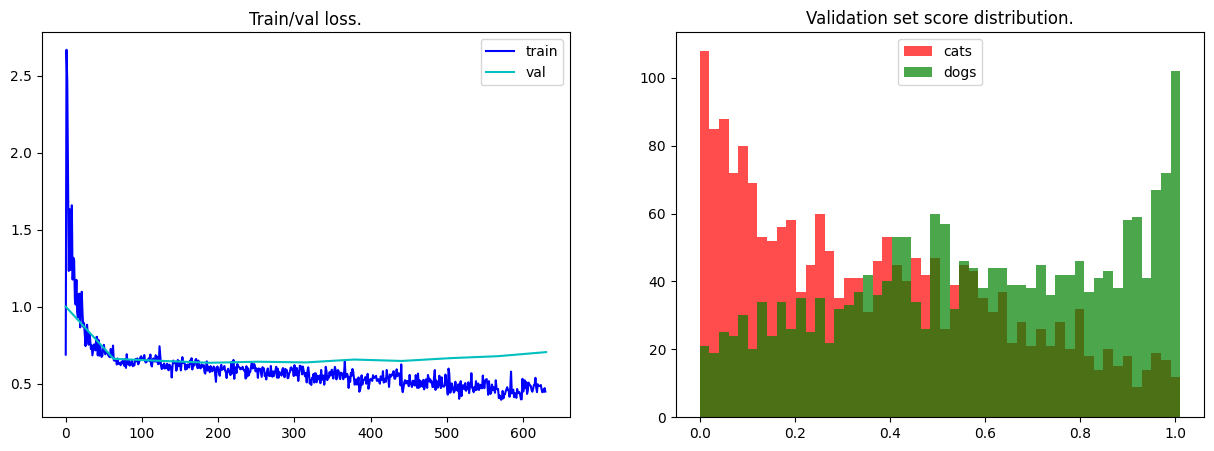

Epoch 10 of 10 took 72.297s


In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
opt.zero_grad()
ckpt_name = 'model_base.ckpt'
model = model.to(device)
model, opt = train_model(model, train_batch_gen, val_batch_gen, opt,ckpt_name=ckpt_name, n_epochs=10)



## Evaluate the best model using test set

In [ ]:
best_model = None
with open(ckpt_name, 'rb') as f:
    best_model = torch.load(f)

val_stats = test_model(best_model, val_batch_gen, 'val')
test_stats = test_model(best_model, test_batch_gen, 'test')

if val_stats['f1_score'] > 0.75 and test_stats['f1_score'] > 0.75:
    print('You have made fully-connected NN perform surprisingly well, call for the assistant.')
else:
    print('Well done, move on to next block to improve performance.')

# Task I: small convolution net
## First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 4 classic convolutional blocks `convolution->relu->pool`:
  * 3x3 convolution with 32 -> 32 -> 64 -> 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout
* Dense layer with 128 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

__HACK_OF_THE_DAY_3__  : it might be useful to use 'VGG-like' structure as a baseline for this task:
    * every CNN layer with 2x2 maxpooling / stride=2 should be followed by increasing the number of output channels x2
    * before the fully-connected layer the tensor H and W should be relatively small (less than 10)
    * in other words, the less H and W of tensor are, the more should you increase C in order to keep more information

In [ ]:
model_cnn = nn.Sequential()

nn.Conv2d()
# Your code here: CONV->POOL->CONV-POOL->... as many as you wish
model_cnn.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3))
model_cnn.add_module('relu1', nn.ReLU())
model_cnn.add_module('max_pooling1', nn.MaxPool2d(kernel_size=2, stride=2))

model_cnn.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3))
model_cnn.add_module('relu2', nn.ReLU())
model_cnn.add_module('max_pooling2', nn.MaxPool2d(kernel_size=2, stride=2))

model_cnn.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3))
model_cnn.add_module('relu3', nn.ReLU())
model_cnn.add_module('max_pooling3', nn.MaxPool2d(kernel_size=2, stride=2))

model_cnn.add_module('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3))
model_cnn.add_module('relu4', nn.ReLU())
model_cnn.add_module('max_pooling4', nn.MaxPool2d(kernel_size=2, stride=2))

# End of your code here

# global max pooling
model_cnn.add_module('global_max_pooling', nn.AdaptiveMaxPool2d(1))
# dropout for regularization
model_cnn.add_module('dropout', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False))


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [ ]:
summary(model_cnn, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             896
              ReLU-2           [-1, 32, 94, 94]               0
         MaxPool2d-3           [-1, 32, 47, 47]               0
            Conv2d-4           [-1, 32, 45, 45]           9,248
              ReLU-5           [-1, 32, 45, 45]               0
         MaxPool2d-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 64, 20, 20]          18,496
              ReLU-8           [-1, 64, 20, 20]               0
         MaxPool2d-9           [-1, 64, 10, 10]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
AdaptiveMaxPool2d-13            [-1, 128, 1, 1]               0
          Dropout-14            [-1, 12

## Training

We may use the same training pipeline, that we defined above, as it does not depend on model structure.

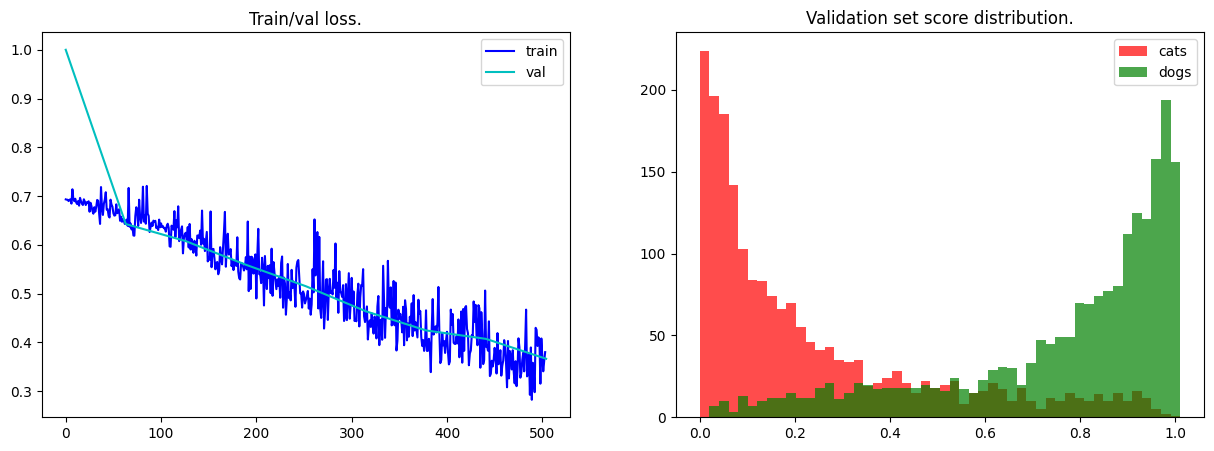

Epoch 8 of 10 took 55.054s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


KeyboardInterrupt: 

In [ ]:
model_cnn = model_cnn.to(device)
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
opt.zero_grad()
ckpt_name_cnn='model_cnn.ckpt'
model_cnn, opt = train_model(model_cnn, train_batch_gen, val_batch_gen,opt, ckpt_name=ckpt_name_cnn, n_epochs=10)

**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```
## Evaluation


In [ ]:
best_model_cnn = None
with open(ckpt_name_cnn, 'rb') as f:
    best_model_cnn = torch.load(f, weights_only=False)

val_stats = test_model(best_model_cnn, val_batch_gen, 'val')
test_stats = test_model(best_model_cnn, test_batch_gen, 'test')

if val_stats['f1_score'] > 0.75 and test_stats['f1_score'] > 0.75:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time.')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Results on val set | accuracy: 0.8383 | f1-score: 0.8378


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Results on test set | accuracy: 0.8332 | f1-score: 0.8287


KeyError: 'f1_score'

In [ ]:
# Task 2: Fine-tuning

## In practice it is easier to use pre-trained NN

<img src="img/ft.jpg" width="600">

We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly changing some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)

<img src="img/resnet.png" width="800">

In [ ]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
torch.no_grad()

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(in_features=num_ftrs, out_features=2)

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

In [ ]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

## Training (only for final layer)

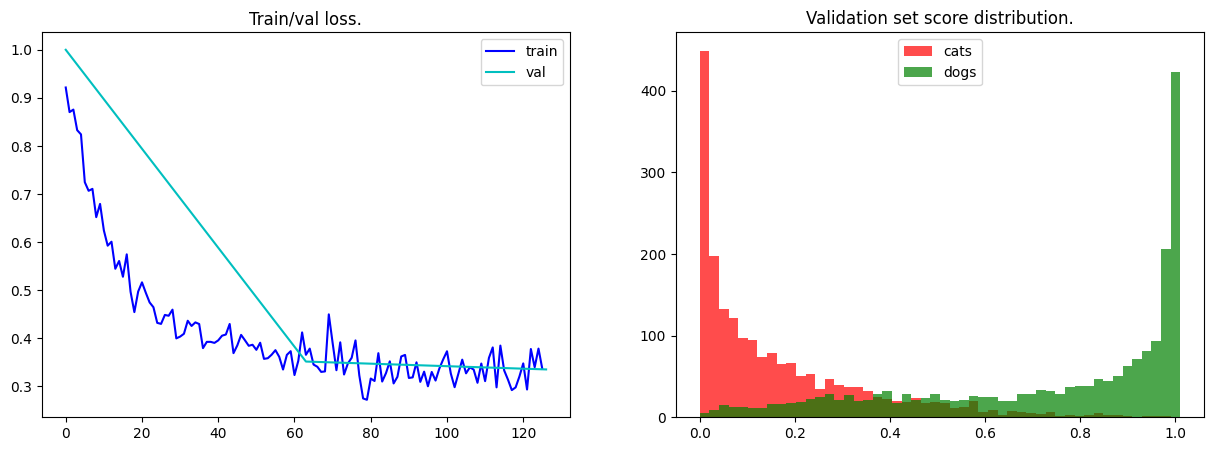

Epoch 2 of 10 took 60.289s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=1e-3)
ckpt_name_resnet18='model_resnet_18_finetune.ckpt'

model_resnet18, opt_resnet = train_model(model_resnet18, train_batch_gen, val_batch_gen, opt_resnet,
                                         ckpt_name=ckpt_name_resnet18, n_epochs=10)

## Evaluation

In [ ]:
best_model_resnet18=None
with open(ckpt_name_resnet18, 'rb') as f:
    best_model_resnet18 = torch.load(f, weights_only=False)

val_stats = test_model(best_model_resnet18, val_batch_gen, 'val')
test_stats = test_model(best_model_resnet18, test_batch_gen, 'test')

if val_stats['f1_score'] > 0.85 and test_stats['f1_score'] > 0.85:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time.')

## Use your own image

In [ ]:
from skimage.io import imread
from skimage.transform import resize

src_1_fp = r"img/example_1.png"
src_2_fp = r"img/example_2.png"

src_1 = imread(src_1_fp)
src_2 = imread(src_2_fp)

resized_1 = resize(src_1, (SIZE_H, SIZE_W), mode='reflect')
resized_2 = resize(src_2, (SIZE_H, SIZE_W), mode='reflect')

# convert to torch.Tensor
tensor_1 = torch.Tensor(np.transpose((resized_1/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)
tensor_2 = torch.Tensor(np.transpose((resized_2/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)

# 'cat' scores
score_1 = F.softmax(best_model_resnet18(tensor_1), 1)[0][0].detach().cpu().numpy()
score_2 = F.softmax(best_model_resnet18(tensor_2), 1)[0][0].detach().cpu().numpy()

In [ ]:
get_label = lambda x: ('cat' if x > 0.5 else 'dog') + ': {:.4f}'.format(x)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(src_1)
plt.title(get_label(score_1))
plt.subplot(122)
plt.imshow(src_2)
plt.title(get_label(score_2))
plt.show()

```
```


# Task 3: adding normalization and different model initialization
## Let's get back to hard work
* Improve the task 1 CNN architecture  with the following:
  * Add batch norm (with default params) between convolution and ReLU
    * nn.BatchNorm*d (1d for dense, 2d for conv)
    * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least __80%__ validation accuracy at peak.
* Use the following model class to simplify the inference


To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [ ]:
# Custom model class

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, stride=stride, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()

        self.model = nn.Sequential(
            conv_block_3x3(3, 32),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(32, 32),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(32, 64),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(64, 128),
            nn.AdaptiveMaxPool2d(1),
            Flatten()
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, EMBEDDING_SIZE),
            nn.ReLU()
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x

In [ ]:
# outputs are here for convenience
model_cnn_norm = MyModel(3)
summary(model_cnn_norm, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             896
       BatchNorm2d-2           [-1, 32, 94, 94]              64
              ReLU-3           [-1, 32, 94, 94]               0
         MaxPool2d-4           [-1, 32, 47, 47]               0
            Conv2d-5           [-1, 32, 45, 45]           9,248
       BatchNorm2d-6           [-1, 32, 45, 45]              64
              ReLU-7           [-1, 32, 45, 45]               0
         MaxPool2d-8           [-1, 32, 22, 22]               0
            Conv2d-9           [-1, 64, 20, 20]          18,496
      BatchNorm2d-10           [-1, 64, 20, 20]             128
             ReLU-11           [-1, 64, 20, 20]               0
        MaxPool2d-12           [-1, 64, 10, 10]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
      BatchNorm2d-14            [-1, 12

## Training

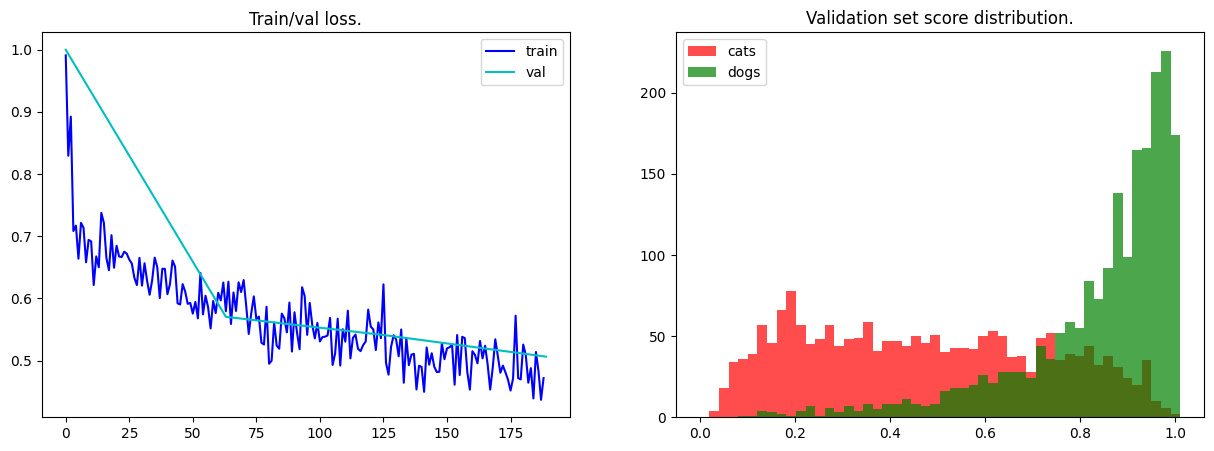

Epoch 3 of 30 took 74.462s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_cnn_norm = model_cnn_norm.to(device)
opt = torch.optim.Adam(model_cnn_norm.parameters(), lr=1e-3)
ckpt_name_cnn_norm='model_cnn_norm.ckpt'
model_cnn_norm, opt = train_model(model_cnn_norm, train_batch_gen, val_batch_gen, opt, ckpt_name=ckpt_name_cnn_norm)

## Evaluation

In [ ]:
best_model_cnn_norm = None
with open(ckpt_name_cnn_norm, 'rb') as f:
    best_model_cnn_norm = torch.load(f)

val_stats = test_model(best_model_cnn_norm, val_batch_gen, 'val')
test_stats = test_model(best_model_cnn_norm, test_batch_gen, 'test')

if val_stats['f1_score'] > 0.8 and test_stats['f1_score'] > 0.8:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time or change CNN architecture.')


# Task 4: Data Augmentation (bonus area)

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly changes image color (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)



In [ ]:
transformer_augmented = transforms.Compose([
    transforms.Resize((3 * SIZE_H // 2, 2 * SIZE_W // 2)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomCrop((SIZE_H, SIZE_W)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)]
)

In [ ]:
# Load dataset using ImageFolder using transformer with augmentation
# Note: We do not use augmentation for validation or testing
train_dataset_aug = torchvision.datasets.ImageFolder(DATA_PATH, transform=transformer_augmented)

train_aug_batch_gen = torch.utils.data.DataLoader(train_dataset_aug,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class_names_aug = train_dataset_aug.classes

Let's look at some image examples

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


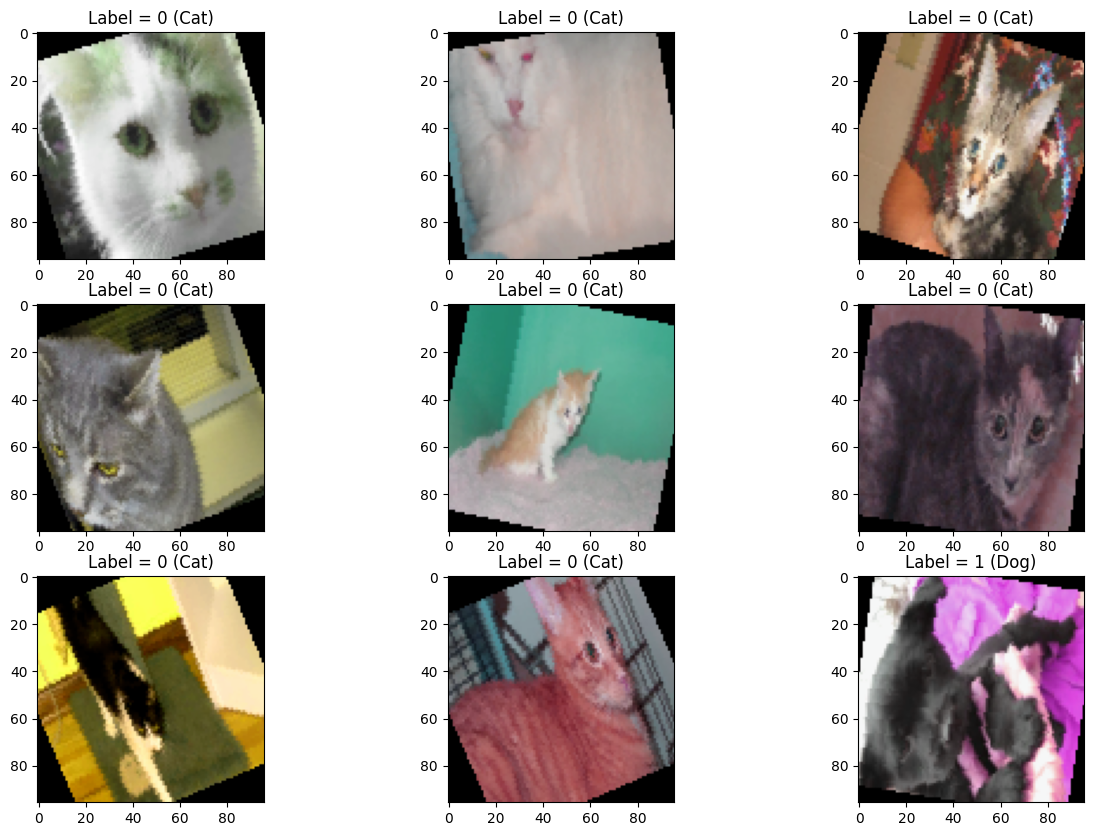

In [ ]:
plot_from_batch_generator(train_aug_batch_gen, class_names_aug)

Note that we did not change test_dataset, as we do not need to augment image data in it.

Let's retrain our model, saving it to another variable

## Training

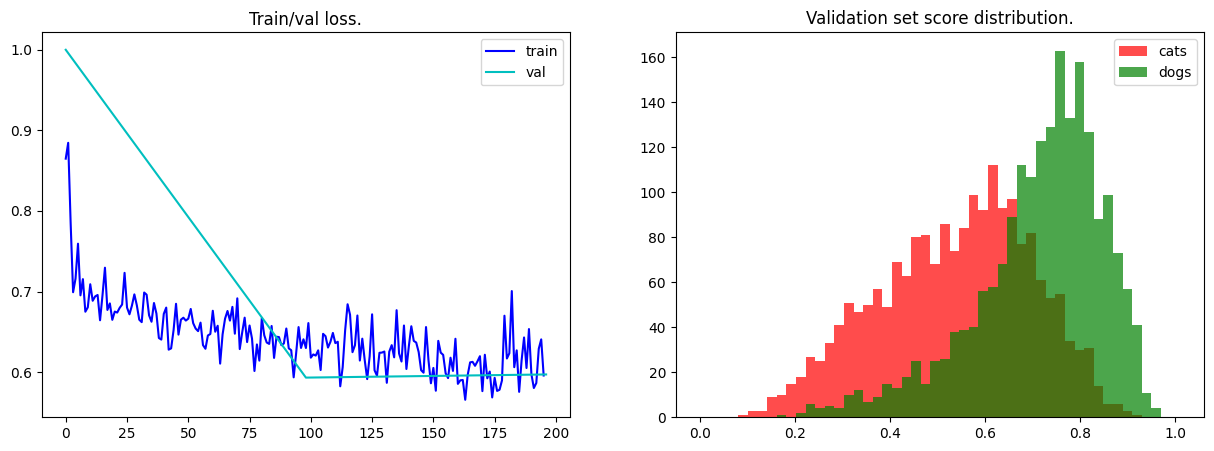

Epoch 2 of 60 took 186.941s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/98 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
model_cnn_aug = MyModel(3).to(device)
opt = torch.optim.Adam(model_cnn_aug.parameters(), lr=1e-3)
ckpt_name_aug='model_cnn_aug.ckpt'
model_cnn_aug, opt = train_model(model_cnn_aug, train_aug_batch_gen, val_batch_gen, opt,
                                                         ckpt_name=ckpt_name_aug, n_epochs=2 * EPOCH_NUM)

In [ ]:
## Evaluation

In [ ]:
best_model_cnn_aug=None
with open(ckpt_name_aug, 'rb') as f:
    best_model_cnn_aug = torch.load(f)

val_stats = test_model(best_model_cnn_aug, val_batch_gen, 'val')
test_stats = test_model(best_model_cnn_aug, test_batch_gen, 'test')
if val_stats['f1_score'] > 0.9 and test_stats['f1_score'] > 0.9:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time or change augmentation scheme.')

In [ ]:
best_model_cnn_aug=None
with open(ckpt_name_aug, 'rb') as f:
    best_model_cnn_aug = torch.load(f)

val_stats = test_model(best_model_cnn_aug, val_batch_gen, 'val')
test_stats = test_model(best_model_cnn_aug, test_batch_gen, 'test')

## Dark Magic (some practical tricks and issues)

<img src="img/dm.png" width="600">